In [ ]:
!pip install seaborn
!pip install matplotlib
!pip install datetime
!pip install pandas
!pip install --upgrade pandas_datareader
!pip install numpy
!pip install os
!pip install tensorflow 

import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import pandas_datareader as web # to read data from web
import numpy as np
import os
import tensorflow as tf


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 777 kB/s 
     |████████████████████████████████| 254 kB 14.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 6.7 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/si

In [ ]:
# Proof of Concept
# Import TX Instruments stock data using pandas_datareader from Yahoo Finance
txn_data= web.DataReader('TXN',data_source="yahoo",start='2014-01-01',end='2022-02-02')
print(txn_data.head())
print(txn_data.shape)

                 High        Low       Open      Close     Volume  Adj Close
Date                                                                        
2014-01-02  43.500000  42.880001  43.439999  43.099998  6959200.0  33.988426
2014-01-03  43.459999  42.970001  43.119999  43.290001  4693300.0  34.138260
2014-01-06  43.279999  42.849998  43.250000  42.930000  4446300.0  33.854370
2014-01-07  43.110001  42.639999  42.980000  42.700001  5078900.0  33.672977
2014-01-08  43.320000  42.619999  42.959999  43.290001  6353500.0  34.138260
(2037, 6)


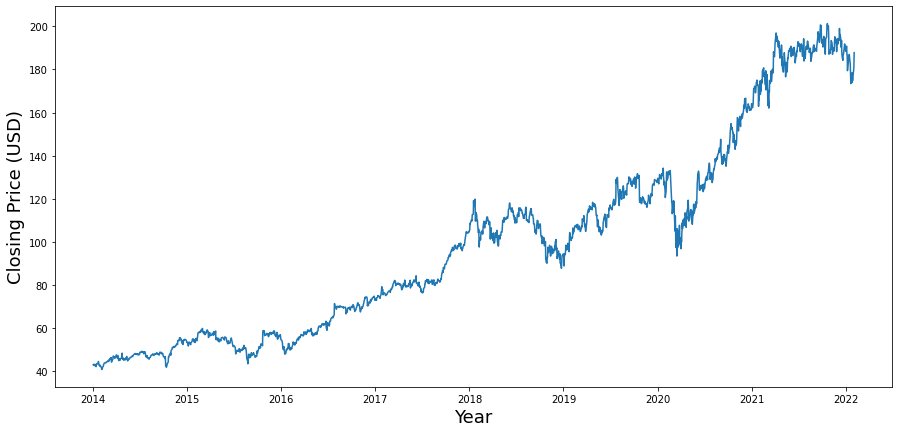

In [ ]:
# Plot the history of the companies closing price in $
plt.figure(figsize=(15,7))
sns.lineplot(x = txn_data.index, y = txn_data['Close'])
plt.xlabel('Year', fontsize=18)
plt.ylabel('Closing Price (USD)',fontsize=18)
plt.show()

In [ ]:
# Split the dataset into a train and test set
data_to_train = txn_data[:1530]
data_to_test = txn_data[1530:]

# Save the resulting data to csv files
data_to_train.to_csv('train_data.csv')
data_to_test.to_csv('test_data.csv')

txn_data= txn_data.iloc[: , 3:4]
print(txn_data.head())


                Close
Date                 
2014-01-02  43.099998
2014-01-03  43.290001
2014-01-06  42.930000
2014-01-07  42.700001
2014-01-08  43.290001


In [ ]:
## Create NumPy array
training_dataset= txn_data.iloc[:1750,:].values

test_dataset= txn_data.iloc[1750:,:].values

# Normalize our data
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
scaled_training_dataset= sc.fit_transform(training_dataset)

# 60 timesteps 1 output
x_train = [] # Independent variables
y_train = [] # Dependent variables 
# I am going to append past 60 days data 
for i in range(60,1750):
    x_train.append(scaled_training_dataset[i-60:i,0]) # Appending previous 60 days data not including 60
    y_train.append(scaled_training_dataset[i,0])
    
x_train, y_train= np.array(x_train), np.array(y_train)

x_train, y_train= np.array(x_train), np.array(y_train)
print(x_train.shape, y_train.shape)  # Check the current shape 

# Using AI LSMT Model (Long Short-Term Memory)
x_train= np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1)) # Re shape to 3D as required by LSMT model
x_train.shape


(1690, 60) (1690,)


(1690, 60, 1)

In [ ]:
# Use Tensorflow's Keras models/packages
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

model = Sequential() # Init recurrent neural network

# Adding first LSTM layer and some dropout Dropout regularisation
model.add(LSTM(units=100,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(rate=0.2))
# '' '' second '' '' '' ''
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(rate=0.2))
# '' '' third '' '' '' ''
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(rate=0.2))
# '' '' fourth '' '' '' ''
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(rate=0.2))
# '' '' fifth '' '' '' ''
model.add(LSTM(units=100))
model.add(Dropout(rate=0.2))
# Add output layer
model.add(Dense(units=1))

# Compile and show model (note we're using regression)
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_2 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 60, 100)           8

Note the LSMT model takes 3 arguments: #values, #time-steps, #1-dimensional output

In [ ]:
# Fit our model into the training set
history = model.fit(x_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
53/53 [==============================] - 25s 274ms/step - loss: 0.0158
Epoch 2/100
53/53 [==============================] - 15s 277ms/step - loss: 0.0029
Epoch 3/100
53/53 [==============================] - 16s 303ms/step - loss: 0.0030
Epoch 4/100
53/53 [==============================] - 15s 274ms/step - loss: 0.0028
Epoch 5/100
53/53 [==============================] - 15s 278ms/step - loss: 0.0023
Epoch 6/100
53/53 [==============================] - 16s 293ms/step - loss: 0.0026
Epoch 7/100
53/53 [==============================] - 15s 277ms/step - loss: 0.0030
Epoch 8/100
53/53 [==============================] - 15s 282ms/step - loss: 0.0022
Epoch 9/100
53/53 [==============================] - 16s 308ms/step - loss: 0.0019
Epoch 10/100
53/53 [==============================] - 14s 272ms/step - loss: 0.0020
Epoch 11/100
53/53 [==============================] - 15s 278ms/step - loss: 0.0019
Epoch 12/100
53/53 [==============================] - 17s 322ms/step - loss: 0.0020
E

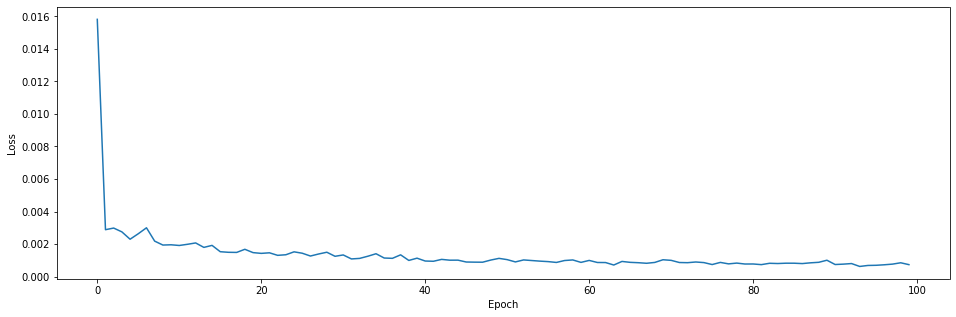

In [ ]:
plt.figure(figsize = (16, 5))
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
training_dataset = pd.read_csv('train_data.csv')
test_dataset = pd.read_csv('test_data.csv')

real_txn_price = test_dataset.iloc[:, 3:4].values
real_txn_price.shape

(287, 1)

In [ ]:

# Use panda's concatenate and scale
data_total= pd.concat([training_dataset['Close'], test_dataset['Close']],  axis=0)
inputs= data_total[len(data_total)-len(test_dataset)-60:].values 
inputs = inputs.reshape(-1,1) 

scaler = MinMaxScaler()

#inputs = sc.transform(inputs)

X_test = []
for i in range(60, 230):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
# 3D format
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
inputs.shape

(347, 1)

In [ ]:
data_total.shape

(2037,)

In [ ]:
X_test.shape

(170, 60, 1)

6/6 [==============================] - 1s 113ms/step


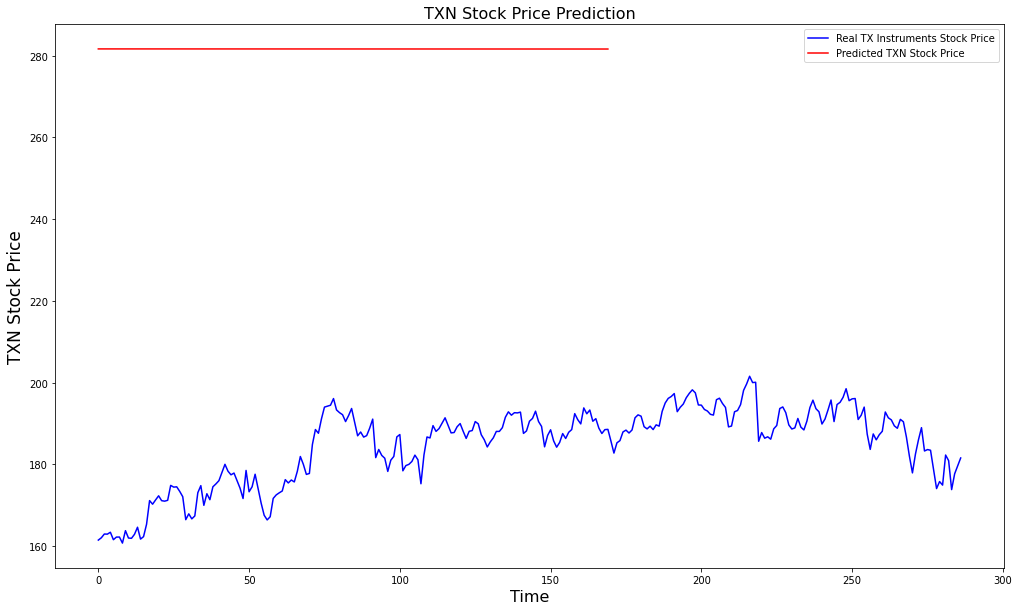

In [ ]:
# Predict using our model
predicted_txn_price = model.predict(X_test)

# Inverse the scaling
predicted_txn_price = sc.inverse_transform(predicted_txn_price)

# Plot result
plt.figure(figsize=(17,10))
plt.plot(real_txn_price, color = 'Blue', label = 'Real TX Instruments Stock Price')
plt.plot(predicted_txn_price, color = 'Red', label = 'Predicted TXN Stock Price')
plt.title('TXN Stock Price Prediction', fontsize = 16)
plt.xlabel('Time', fontsize = 16)
plt.ylabel('TXN Stock Price', fontsize = 17)
plt.legend()
plt.show()